In [11]:
# LIBRARIES

import os
import re
import json
import copy
import numpy as np                                                                   

import unicodedata                                                                   
import pandas as pd
from itertools import cycle
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [12]:
# URLs

train_set_url = "kaggle/input/ys19-2023-assignment-3/train_set.csv"
valid_set_url = "kaggle/input/ys19-2023-assignment-3/valid_set.csv"
test_set_url = "kaggle/input/ys19-2023-assignment-3/test_set.csv"
word_embeddings_url = "kaggle/input/word-embeddings/word2vec.model"

In [13]:
# GPU DATA TRANSFER

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
class Preprocess:
    
    __word_embeddings = None
    __vector_dimension = None

    __data_normalization = None
    __normalization_parameters = None
    
    __parties_to_numbers = {'ND' : 1.0, 'SYRIZA' : 2.0, 'PASOK' : 3.0, 'KKE' : 4.0, 'DIEM' : 5.0, 'ELL_LYSI' : 6.0}
    __sentiments_to_numbers = {'POSITIVE': 0, 'NEUTRAL': 1, 'NEGATIVE': 2}
    __numbers_to_sentiments = {0 : 'POSITIVE' , 1 : 'NEUTRAL', 2 : 'NEGATIVE'}
    
    __stopwords = ['Α', 'ΑΔΙΑΚΟΠΑ', 'ΑΙ', 'ΑΚΟΜΑ', 'ΑΚΟΜΗ', 'ΑΚΡΙΒΩΣ', 'ΑΛΗΘΕΙΑ', 'ΑΛΗΘΙΝΑ', 'ΑΛΛΑ', 'ΑΛΛΑΧΟΥ', 'ΑΛΛΕΣ', 'ΑΛΛΗ', 'ΑΛΛΗΝ', 'ΑΛΛΗΣ', 'ΑΛΛΙΩΣ', 'ΑΛΛΙΩΤΙΚΑ', 'ΑΛΛΟ', 'ΑΛΛΟΙ', 'ΑΛΛΟΙΩΣ', 'ΑΛΛΟΙΩΤΙΚΑ', 'ΑΛΛΟΝ', 'ΑΛΛΟΣ', 'ΑΛΛΟΤΕ', 'ΑΛΛΟΥ', 'ΑΛΛΟΥΣ', 'ΑΛΛΩΝ', 'ΑΜΑ', 'ΑΜΕΣΑ', 'ΑΜΕΣΩΣ', 'ΑΝ', 'ΑΝΑ', 'ΑΝΑΜΕΣΑ', 'ΑΝΑΜΕΤΑΞΥ', 'ΑΝΕΥ', 'ΑΝΤΙ', 'ΑΝΤΙΠΕΡΑ', 'ΑΝΤΙΣ', 'ΑΝΩ', 'ΑΝΩΤΕΡΩ', 'ΑΞΑΦΝΑ', 'ΑΠ', 'ΑΠΕΝΑΝΤΙ', 'ΑΠΟ', 'ΑΠΟΨΕ', 'ΑΡΑ', 'ΑΡΑΓΕ', 'ΑΡΓΑ', 'ΑΡΓΟΤΕΡΟ', 'ΑΡΙΣΤΕΡΑ', 'ΑΡΚΕΤΑ', 'ΑΡΧΙΚΑ', 'ΑΣ', 'ΑΥΡΙΟ', 'ΑΥΤΑ', 'ΑΥΤΕΣ', 'ΑΥΤΗ', 'ΑΥΤΗΝ', 'ΑΥΤΗΣ', 'ΑΥΤΟ', 'ΑΥΤΟΙ', 'ΑΥΤΟΝ', 'ΑΥΤΟΣ', 'ΑΥΤΟΥ', 'ΑΥΤΟΥΣ', 'ΑΥΤΩΝ', 'ΑΦΟΤΟΥ', 'ΑΦΟΥ', 'Β', 'ΒΕΒΑΙΑ', 'ΒΕΒΑΙΟΤΑΤΑ', 'Γ', 'ΓΙ', 'ΓΙΑ', 'ΓΙΑΤΙ', 'ΓΡΗΓΟΡΑ', 'ΓΥΡΩ', 'Δ', 'ΔΑ', 'ΔΕ', 'ΔΕΝ', 'ΔΕΙΝΑ', 'ΔΕΞΙΑ', 'ΔΗΘΕΝ', 'ΔΗΛΑΔΗ', 'ΔΙ', 'ΔΙΑ', 'ΔΙΑΡΚΩΣ', 'ΔΙΚΑ', 'ΔΙΚΟ', 'ΔΙΚΟΙ', 'ΔΙΚΟΣ', 'ΔΙΚΟΥ', 'ΔΙΚΟΥΣ', 'ΔΙΟΛΟΥ', 'ΔΙΠΛΑ', 'ΔΙΧΩΣ', 'Ε', 'ΕΑΝ', 'ΕΑΥΤΟ', 'ΕΑΥΤΟΝ', 'ΕΑΥΤΟΥ', 'ΕΑΥΤΟΥΣ', 'ΕΑΥΤΩΝ', 'ΕΓΚΑΙΡΑ', 'ΕΓΚΑΙΡΩΣ', 'ΕΓΩ', 'ΕΔΩ', 'ΕΙΔΕΜΗ', 'ΕΙΘΕ', 'ΕΙΜΑΙ', 'ΕΙΜΑΣΤΕ', 'ΕΙΝΑΙ', 'ΕΙΣ', 'ΕΙΣΑΙ', 'ΕΙΣΑΣΤΕ', 'ΕΙΣΤΕ', 'ΕΙΤΕ', 'ΕΙΧΑ', 'ΕΙΧΑΜΕ', 'ΕΙΧΑΝ', 'ΕΙΧΑΤΕ', 'ΕΙΧΕ', 'ΕΙΧΕΣ', 'ΕΚΑΣΤΑ', 'ΕΚΑΣΤΕΣ', 'ΕΚΑΣΤΗ', 'ΕΚΑΣΤΗΝ', 'ΕΚΑΣΤΗΣ', 'ΕΚΑΣΤΟ', 'ΕΚΑΣΤΟΙ', 'ΕΚΑΣΤΟΝ', 'ΕΚΑΣΤΟΣ', 'ΕΚΑΣΤΟΥ', 'ΕΚΑΣΤΟΥΣ', 'ΕΚΑΣΤΩΝ', 'ΕΚΕΙ', 'ΕΚΕΙΝΑ', 'ΕΚΕΙΝΕΣ', 'ΕΚΕΙΝΗ', 'ΕΚΕΙΝΗΝ', 'ΕΚΕΙΝΗΣ', 'ΕΚΕΙΝΟ', 'ΕΚΕΙΝΟΙ', 'ΕΚΕΙΝΟΝ', 'ΕΚΕΙΝΟΣ', 'ΕΚΕΙΝΟΥ', 'ΕΚΕΙΝΟΥΣ', 'ΕΚΕΙΝΩΝ', 'ΕΚΤΟΣ', 'ΕΜΑΣ', 'ΕΜΕΙΣ', 'ΕΜΕΝΑ', 'ΕΜΠΡΟΣ', 'ΕΝ', 'ΕΝΑ', 'ΕΝΑΝ', 'ΕΝΑΣ', 'ΕΝΟΣ', 'ΕΝΤΕΛΩΣ', 'ΕΝΤΟΣ', 'ΕΝΤΩΜΕΤΑΞΥ', 'ΕΝΩ', 'ΕΞ', 'ΕΞΑΦΝΑ', 'ΕΞΗΣ', 'ΕΞΙΣΟΥ', 'ΕΞΩ', 'ΕΠΑΝΩ', 'ΕΠΕΙΔΗ', 'ΕΠΕΙΤΑ', 'ΕΠΙ', 'ΕΠΙΣΗΣ', 'ΕΠΟΜΕΝΩΣ', 'ΕΣΑΣ', 'ΕΣΕΙΣ', 'ΕΣΕΝΑ', 'ΕΣΤΩ', 'ΕΣΥ', 'ΕΤΕΡΑ', 'ΕΤΕΡΑΙ', 'ΕΤΕΡΑΣ', 'ΕΤΕΡΕΣ', 'ΕΤΕΡΗ', 'ΕΤΕΡΗΣ', 'ΕΤΕΡΟ', 'ΕΤΕΡΟΙ', 'ΕΤΕΡΟΝ', 'ΕΤΕΡΟΣ', 'ΕΤΕΡΟΥ', 'ΕΤΕΡΟΥΣ', 'ΕΤΕΡΩΝ', 'ΕΤΟΥΤΑ', 'ΕΤΟΥΤΕΣ', 'ΕΤΟΥΤΗ', 'ΕΤΟΥΤΗΝ', 'ΕΤΟΥΤΗΣ', 'ΕΤΟΥΤΟ', 'ΕΤΟΥΤΟΙ', 'ΕΤΟΥΤΟΝ', 'ΕΤΟΥΤΟΣ', 'ΕΤΟΥΤΟΥ', 'ΕΤΟΥΤΟΥΣ', 'ΕΤΟΥΤΩΝ', 'ΕΤΣΙ', 'ΕΥΓΕ', 'ΕΥΘΥΣ', 'ΕΥΤΥΧΩΣ', 'ΕΦΕΞΗΣ', 'ΕΧΕΙ', 'ΕΧΕΙΣ', 'ΕΧΕΤΕ', 'ΕΧΘΕΣ', 'ΕΧΟΜΕ', 'ΕΧΟΥΜΕ', 'ΕΧΟΥΝ', 'ΕΧΤΕΣ', 'ΕΧΩ', 'ΕΩΣ', 'Ζ', 'Η', 'ΗΔΗ', 'ΗΜΑΣΤΑΝ', 'ΗΜΑΣΤΕ', 'ΗΜΟΥΝ', 'ΗΣΑΣΤΑΝ', 'ΗΣΑΣΤΕ', 'ΗΣΟΥΝ', 'ΗΤΑΝ', 'ΗΤΑΝΕ', 'ΗΤΟΙ', 'ΗΤΤΟΝ', 'Θ', 'ΘΑ', 'Ι', 'ΙΔΙΑ', 'ΙΔΙΑΝ', 'ΙΔΙΑΣ', 'ΙΔΙΕΣ', 'ΙΔΙΟ', 'ΙΔΙΟΙ', 'ΙΔΙΟΝ', 'ΙΔΙΟΣ', 'ΙΔΙΟΥ', 'ΙΔΙΟΥΣ', 'ΙΔΙΩΝ', 'ΙΔΙΩΣ', 'ΙΙ', 'ΙΙΙ', 'ΙΣΑΜΕ', 'ΙΣΙΑ', 'ΙΣΩΣ', 'Κ', 'ΚΑΘΕ', 'ΚΑΘΕΜΙΑ', 'ΚΑΘΕΜΙΑΣ', 'ΚΑΘΕΝΑ', 'ΚΑΘΕΝΑΣ', 'ΚΑΘΕΝΟΣ', 'ΚΑΘΕΤΙ', 'ΚΑΘΟΛΟΥ', 'ΚΑΘΩΣ', 'ΚΑΙ', 'ΚΑΚΑ', 'ΚΑΚΩΣ', 'ΚΑΛΑ', 'ΚΑΛΩΣ', 'ΚΑΜΙΑ', 'ΚΑΜΙΑΝ', 'ΚΑΜΙΑΣ', 'ΚΑΜΠΟΣΑ', 'ΚΑΜΠΟΣΕΣ', 'ΚΑΜΠΟΣΗ', 'ΚΑΜΠΟΣΗΝ', 'ΚΑΜΠΟΣΗΣ', 'ΚΑΜΠΟΣΟ', 'ΚΑΜΠΟΣΟΙ', 'ΚΑΜΠΟΣΟΝ', 'ΚΑΜΠΟΣΟΣ', 'ΚΑΜΠΟΣΟΥ', 'ΚΑΜΠΟΣΟΥΣ', 'ΚΑΜΠΟΣΩΝ', 'ΚΑΝΕΙΣ', 'ΚΑΝΕΝ', 'ΚΑΝΕΝΑ', 'ΚΑΝΕΝΑΝ', 'ΚΑΝΕΝΑΣ', 'ΚΑΝΕΝΟΣ', 'ΚΑΠΟΙΑ', 'ΚΑΠΟΙΑΝ', 'ΚΑΠΟΙΑΣ', 'ΚΑΠΟΙΕΣ', 'ΚΑΠΟΙΟ', 'ΚΑΠΟΙΟΙ', 'ΚΑΠΟΙΟΝ', 'ΚΑΠΟΙΟΣ', 'ΚΑΠΟΙΟΥ', 'ΚΑΠΟΙΟΥΣ', 'ΚΑΠΟΙΩΝ', 'ΚΑΠΟΤΕ', 'ΚΑΠΟΥ', 'ΚΑΠΩΣ', 'ΚΑΤ', 'ΚΑΤΑ', 'ΚΑΤΙ', 'ΚΑΤΙΤΙ', 'ΚΑΤΟΠΙΝ', 'ΚΑΤΩ', 'ΚΙ', 'ΚΙΟΛΑΣ', 'ΚΛΠ', 'ΚΟΝΤΑ', 'ΚΤΛ', 'ΚΥΡΙΩΣ', 'Λ', 'ΛΙΓΑΚΙ', 'ΛΙΓΟ', 'ΛΙΓΩΤΕΡΟ', 'ΛΟΓΩ', 'ΛΟΙΠΑ', 'ΛΟΙΠΟΝ', 'Μ', 'ΜΑ', 'ΜΑΖΙ', 'ΜΑΚΑΡΙ', 'ΜΑΚΡΥΑ', 'ΜΑΛΙΣΤΑ', 'ΜΑΛΛΟΝ', 'ΜΑΣ', 'ΜΕ', 'ΜΕΘΑΥΡΙΟ', 'ΜΕΙΟΝ', 'ΜΕΛΕΙ', 'ΜΕΛΛΕΤΑΙ', 'ΜΕΜΙΑΣ', 'ΜΕΝ', 'ΜΕΡΙΚΑ', 'ΜΕΡΙΚΕΣ', 'ΜΕΡΙΚΟΙ', 'ΜΕΡΙΚΟΥΣ', 'ΜΕΡΙΚΩΝ', 'ΜΕΣΑ', 'ΜΕΤ', 'ΜΕΤΑ', 'ΜΕΤΑΞΥ', 'ΜΕΧΡΙ', 'ΜΗ', 'ΜΗΔΕ', 'ΜΗΝ', 'ΜΗΠΩΣ', 'ΜΗΤΕ', 'ΜΙΑ', 'ΜΙΑΝ', 'ΜΙΑΣ', 'ΜΟΛΙΣ', 'ΜΟΛΟΝΟΤΙ', 'ΜΟΝΑΧΑ', 'ΜΟΝΕΣ', 'ΜΟΝΗ', 'ΜΟΝΗΝ', 'ΜΟΝΗΣ', 'ΜΟΝΟ', 'ΜΟΝΟΙ', 'ΜΟΝΟΜΙΑΣ', 'ΜΟΝΟΣ', 'ΜΟΝΟΥ', 'ΜΟΝΟΥΣ', 'ΜΟΝΩΝ', 'ΜΟΥ', 'ΜΠΟΡΕΙ', 'ΜΠΟΡΟΥΝ', 'ΜΠΡΑΒΟ', 'ΜΠΡΟΣ', 'Ν', 'ΝΑ', 'ΝΑΙ', 'ΝΩΡΙΣ', 'Ξ', 'ΞΑΝΑ', 'ΞΑΦΝΙΚΑ', 'Ο', 'ΟΙ', 'ΟΛΑ', 'ΟΛΕΣ', 'ΟΛΗ', 'ΟΛΗΝ', 'ΟΛΗΣ', 'ΟΛΟ', 'ΟΛΟΓΥΡΑ', 'ΟΛΟΙ', 'ΟΛΟΝ', 'ΟΛΟΝΕΝ', 'ΟΛΟΣ', 'ΟΛΟΤΕΛΑ', 'ΟΛΟΥ', 'ΟΛΟΥΣ', 'ΟΛΩΝ', 'ΟΛΩΣ', 'ΟΛΩΣΔΙΟΛΟΥ', 'ΟΜΩΣ', 'ΟΠΟΙΑ', 'ΟΠΟΙΑΔΗΠΟΤΕ', 'ΟΠΟΙΑΝ', 'ΟΠΟΙΑΝΔΗΠΟΤΕ', 'ΟΠΟΙΑΣ', 'ΟΠΟΙΑΣΔΗΠΟΤΕ', 'ΟΠΟΙΔΗΠΟΤΕ', 'ΟΠΟΙΕΣ', 'ΟΠΟΙΕΣΔΗΠΟΤΕ', 'ΟΠΟΙΟ', 'ΟΠΟΙΟΔΗΠΟΤΕ', 'ΟΠΟΙΟΙ', 'ΟΠΟΙΟΝ', 'ΟΠΟΙΟΝΔΗΠΟΤΕ', 'ΟΠΟΙΟΣ', 'ΟΠΟΙΟΣΔΗΠΟΤΕ', 'ΟΠΟΙΟΥ', 'ΟΠΟΙΟΥΔΗΠΟΤΕ', 'ΟΠΟΙΟΥΣ', 'ΟΠΟΙΟΥΣΔΗΠΟΤΕ', 'ΟΠΟΙΩΝ', 'ΟΠΟΙΩΝΔΗΠΟΤΕ', 'ΟΠΟΤΕ', 'ΟΠΟΤΕΔΗΠΟΤΕ', 'ΟΠΟΥ', 'ΟΠΟΥΔΗΠΟΤΕ', 'ΟΠΩΣ', 'ΟΡΙΣΜΕΝΑ', 'ΟΡΙΣΜΕΝΕΣ', 'ΟΡΙΣΜΕΝΩΝ', 'ΟΡΙΣΜΕΝΩΣ', 'ΟΣΑ', 'ΟΣΑΔΗΠΟΤΕ', 'ΟΣΕΣ', 'ΟΣΕΣΔΗΠΟΤΕ', 'ΟΣΗ', 'ΟΣΗΔΗΠΟΤΕ', 'ΟΣΗΝ', 'ΟΣΗΝΔΗΠΟΤΕ', 'ΟΣΗΣ', 'ΟΣΗΣΔΗΠΟΤΕ', 'ΟΣΟ', 'ΟΣΟΔΗΠΟΤΕ', 'ΟΣΟΙ', 'ΟΣΟΙΔΗΠΟΤΕ', 'ΟΣΟΝ', 'ΟΣΟΝΔΗΠΟΤΕ', 'ΟΣΟΣ', 'ΟΣΟΣΔΗΠΟΤΕ', 'ΟΣΟΥ', 'ΟΣΟΥΔΗΠΟΤΕ', 'ΟΣΟΥΣ', 'ΟΣΟΥΣΔΗΠΟΤΕ', 'ΟΣΩΝ', 'ΟΣΩΝΔΗΠΟΤΕ', 'ΟΤΑΝ', 'ΟΤΙ', 'ΟΤΙΔΗΠΟΤΕ', 'ΟΤΟΥ', 'ΟΥ', 'ΟΥΔΕ', 'ΟΥΤΕ', 'ΟΧΙ', 'Π', 'ΠΑΛΙ', 'ΠΑΝΤΟΤΕ', 'ΠΑΝΤΟΥ', 'ΠΑΝΤΩΣ', 'ΠΑΡΑ', 'ΠΕΡΑ', 'ΠΕΡΙ', 'ΠΕΡΙΠΟΥ', 'ΠΕΡΙΣΣΟΤΕΡΟ', 'ΠΕΡΣΙ', 'ΠΕΡΥΣΙ', 'ΠΙΑ', 'ΠΙΘΑΝΟΝ', 'ΠΙΟ', 'ΠΙΣΩ', 'ΠΛΑΙ', 'ΠΛΕΟΝ', 'ΠΛΗΝ', 'ΠΟΙΑ', 'ΠΟΙΑΝ', 'ΠΟΙΑΣ', 'ΠΟΙΕΣ', 'ΠΟΙΟ', 'ΠΟΙΟΙ', 'ΠΟΙΟΝ', 'ΠΟΙΟΣ', 'ΠΟΙΟΥ', 'ΠΟΙΟΥΣ', 'ΠΟΙΩΝ', 'ΠΟΛΥ', 'ΠΟΣΕΣ', 'ΠΟΣΗ', 'ΠΟΣΗΝ', 'ΠΟΣΗΣ', 'ΠΟΣΟΙ', 'ΠΟΣΟΣ', 'ΠΟΣΟΥΣ', 'ΠΟΤΕ', 'ΠΟΥ', 'ΠΟΥΘΕ', 'ΠΟΥΘΕΝΑ', 'ΠΡΕΠΕΙ', 'ΠΡΙΝ', 'ΠΡΟ', 'ΠΡΟΚΕΙΜΕΝΟΥ', 'ΠΡΟΚΕΙΤΑΙ', 'ΠΡΟΠΕΡΣΙ', 'ΠΡΟΣ', 'ΠΡΟΤΟΥ', 'ΠΡΟΧΘΕΣ', 'ΠΡΟΧΤΕΣ', 'ΠΡΩΤΥΤΕΡΑ', 'ΠΩΣ', 'ΡΕ', 'Σ', 'ΣΑΝ', 'ΣΑΣ', 'ΣΕ', 'ΣΕΙΣ', 'ΣΗΜΕΡΑ', 'ΣΙΓΑ', 'ΣΟΥ', 'ΣΤΑ', 'ΣΤΗ', 'ΣΤΗΝ', 'ΣΤΗΣ', 'ΣΤΙΣ', 'ΣΤΟ', 'ΣΤΟΝ', 'ΣΤΟΥ', 'ΣΤΟΥΣ', 'ΣΤΩΝ', 'ΣΥΓΧΡΟΝΩΣ', 'ΣΥΝ', 'ΣΥΝΑΜΑ', 'ΣΥΝΕΠΩΣ', 'ΣΥΝΗΘΩΣ', 'ΣΥΧΝΑ', 'ΣΥΧΝΑΣ', 'ΣΥΧΝΕΣ', 'ΣΥΧΝΗ', 'ΣΥΧΝΗΝ', 'ΣΥΧΝΗΣ', 'ΣΥΧΝΟ', 'ΣΥΧΝΟΙ', 'ΣΥΧΝΟΝ', 'ΣΥΧΝΟΣ', 'ΣΥΧΝΟΥ', 'ΣΥΧΝΟΥΣ', 'ΣΥΧΝΩΝ', 'ΣΥΧΝΩΣ', 'ΣΧΕΔΟΝ', 'ΣΩΣΤΑ', 'Τ', 'ΤΑ', 'ΤΑΔΕ', 'ΤΑΥΤΑ', 'ΤΑΥΤΕΣ', 'ΤΑΥΤΗ', 'ΤΑΥΤΗΝ', 'ΤΑΥΤΗΣ', 'ΤΑΥΤΟ', 'ΤΑΥΤΟΝ', 'ΤΑΥΤΟΣ', 'ΤΑΥΤΟΥ', 'ΤΑΥΤΩΝ', 'ΤΑΧΑ', 'ΤΑΧΑΤΕ', 'ΤΕΛΙΚΑ', 'ΤΕΛΙΚΩΣ', 'ΤΕΣ', 'ΤΕΤΟΙΑ', 'ΤΕΤΟΙΑΝ', 'ΤΕΤΟΙΑΣ', 'ΤΕΤΟΙΕΣ', 'ΤΕΤΟΙΟ', 'ΤΕΤΟΙΟΙ', 'ΤΕΤΟΙΟΝ', 'ΤΕΤΟΙΟΣ', 'ΤΕΤΟΙΟΥ', 'ΤΕΤΟΙΟΥΣ', 'ΤΕΤΟΙΩΝ', 'ΤΗ', 'ΤΗΝ', 'ΤΗΣ', 'ΤΙ', 'ΤΙΠΟΤΑ', 'ΤΙΠΟΤΕ', 'ΤΙΣ', 'ΤΟ', 'ΤΟΙ', 'ΤΟΝ', 'ΤΟΣ', 'ΤΟΣΑ', 'ΤΟΣΕΣ', 'ΤΟΣΗ', 'ΤΟΣΗΝ', 'ΤΟΣΗΣ', 'ΤΟΣΟ', 'ΤΟΣΟΙ', 'ΤΟΣΟΝ', 'ΤΟΣΟΣ', 'ΤΟΣΟΥ', 'ΤΟΣΟΥΣ', 'ΤΟΣΩΝ', 'ΤΟΤΕ', 'ΤΟΥ', 'ΤΟΥΛΑΧΙΣΤΟ', 'ΤΟΥΛΑΧΙΣΤΟΝ', 'ΤΟΥΣ', 'ΤΟΥΤΑ', 'ΤΟΥΤΕΣ', 'ΤΟΥΤΗ', 'ΤΟΥΤΗΝ', 'ΤΟΥΤΗΣ', 'ΤΟΥΤΟ', 'ΤΟΥΤΟΙ', 'ΤΟΥΤΟΙΣ', 'ΤΟΥΤΟΝ', 'ΤΟΥΤΟΣ', 'ΤΟΥΤΟΥ', 'ΤΟΥΤΟΥΣ', 'ΤΟΥΤΩΝ', 'ΤΥΧΟΝ', 'ΤΩΝ', 'ΤΩΡΑ', 'Υ', 'ΥΠ', 'ΥΠΕΡ', 'ΥΠΟ', 'ΥΠΟΨΗ', 'ΥΠΟΨΙΝ', 'ΥΣΤΕΡΑ', 'Φ', 'ΦΕΤΟΣ', 'Χ', 'ΧΑΜΗΛΑ', 'ΧΘΕΣ', 'ΧΤΕΣ', 'ΧΩΡΙΣ', 'ΧΩΡΙΣΤΑ', 'Ψ', 'ΨΗΛΑ', 'Ω', 'ΩΡΑΙΑ', 'ΩΣ', 'ΩΣΑΝ', 'ΩΣΟΤΟΥ', 'ΩΣΠΟΥ', 'ΩΣΤΕ', 'ΩΣΤΟΣΟ', 'ΩΧ']
    
    
    __tokenizer = TweetTokenizer(reduce_len=True)
    
    __clean_URLs = True
    __clean_user_mentions = True
    __clean_hashtags = False
    __clean_symbols_only = False
    __to_uppercase = True
    __clean_stopwords = True
    __clean_intonations = True
    __clean_special_characters = True
    __clean_endings = True
    
    __url_regex = re.compile(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)|(www\.[^ \s]+)')
    __user_mention_regex = re.compile(r'@\w+')
    __hashtag_regex = re.compile(r'#\S+')
    
    def __init__(self,word_embeddings_url):
        self.__load_word_embeddings(word_embeddings_url)
          
    
    def __load_word_embeddings(self, filename):
        model = Word2Vec.load(filename)
        self.__word_embeddings = model.wv
        self.__vector_dimension = model.vector_size
        return

    def __load_dataset(self,dataset_url):
        dataframe = pd.read_csv(dataset_url)
        return dataframe
    
    def __tokenize(self,tweet):
        tokens = self.__tokenizer.tokenize(tweet)
        return tokens
    
    def __remove_URLs(self,tokens):
        final_tokens = []
        for token in tokens:
            if not self.__url_regex.match(token):
                final_tokens.append(token)
        return final_tokens
    
    def __remove_user_mentions(self,tokens):
        final_tokens = []
        for token in tokens:
            if not self.__user_mention_regex.match(token):
                final_tokens.append(token)
        return final_tokens
    
    def __remove_intonations(self,tokens):
        final_tokens = []
        for token in tokens:
            # Break down the token into normal characters and their respective intonations
            transformed_token = unicodedata.normalize('NFD', token)
            final_token = ''
            for character in transformed_token:
                # If the character is not an intonation, add it to the final token
                if not unicodedata.combining(character):
                    final_token += character
            final_tokens.append(final_token)
        return final_tokens
    
    def __convert_to_uppercase(self,tokens):
        final_tokens = []
        for token in tokens:
            # Convert each token to uppercase
            uppercase_token = token.upper()
            final_tokens.append(uppercase_token)
        return final_tokens
    
    def __remove_hashtags(self,tokens):
        final_tokens = []
        if self.__clean_symbols_only:
            for token in tokens:
                no_hashtag_token = token.replace('#', '')
                final_tokens.append(no_hashtag_token)
        else:
            for token in tokens:
                if not self.__hashtag_regex.match(token):
                    final_tokens.append(token)
        return final_tokens
    
    def __remove_special_characters(self,tokens):
        final_tokens = []
        for token in tokens:
            final_token = ''
            for i, character in enumerate(token):
                if i == 0 :
                    if character == "#" :
                        final_token += character
                    else :
                        if character.isalpha():
                            final_token += character
                else :
                    if character.isalpha():
                        final_token += character
            final_tokens.append(final_token)
        return final_tokens
    
    def __remove_stopwords(self,tokens):
        final_tokens = []
        for token in tokens:
            if token not in self.__stopwords:
                final_tokens.append(token)
        return final_tokens
    
    def __remove_endings(self,tokens):
        final_tokens = []
        for token in tokens:
            if token and (token[-1] == "Σ" or token[-1] == "Ν"):
                token = token[:-1]
            final_tokens.append(token)
        return final_tokens

    def __remove_spaces(self,tokens):
        final_tokens = []
        for token in tokens:
            final_token = token.replace(" ","")
            final_tokens.append(final_token)
        return final_tokens

    def __remove_short_tokens(self,tokens):
        final_tokens = []
        for token in tokens:
            if len(token) > 1:
                final_tokens.append(token)
        return final_tokens

    def __clean_tweet(self,tweet):

        tokens = self.__tokenize(tweet)
        
        if self.__clean_URLs:
            tokens = self.__remove_URLs(tokens)
        
        if self.__clean_user_mentions:
            tokens = self.__remove_user_mentions(tokens)
            
        if self.__clean_intonations:
            tokens = self.__remove_intonations(tokens)    
            
        if self.__to_uppercase:
            tokens = self.__convert_to_uppercase(tokens)
            
        if self.__clean_hashtags:
            tokens = self.__remove_hashtags(tokens)
            
        if self.__clean_special_characters:
            tokens = self.__remove_special_characters(tokens)
        
        if self.__clean_stopwords:
            tokens = self.__remove_stopwords(tokens)
         
        if self.__clean_endings:
            tokens = self.__remove_endings(tokens) 
         
        tokens = self.__remove_spaces(tokens)
        
        tokens = self.__remove_short_tokens(tokens)
        
        return tokens

    def __clean_dataset(self,dataset):
        
        clean_tweets = []
        
        for i, row in dataset.iterrows():
            
            tweet = row['Text']
            
            clean_tweet = self.__clean_tweet(tweet)
            
            clean_tweets.append(clean_tweet)
            
        #self.__write_dataset(clean_tweets)    
            
        return clean_tweets
    
    def __find_tweet_embeddings(self,clean_tweets):
        
        tweets_embeddings = []
        
        for tweet in clean_tweets:    
            tweet_embeddings = []
            for word in tweet:
                if word in self.__word_embeddings:
                    tweet_embeddings.append(self.__word_embeddings[word])
            tweets_embeddings.append(tweet_embeddings)
            
        return tweets_embeddings

    def __pad_tweet_embeddings(self, tweet_embeddings):
        
    
        # Determine the maximum length of a tweet
        max_length = max(len(tweet) for tweet in tweet_embeddings) + 1  # +1 for additional [0.5, ..., 0.5] vector
    
        # Determine the embedding dimension
        embedding_dimension = len(tweet_embeddings[0][0])
    
        # Placeholder for padded tweets
        padded_tweets = []
    
        # Padding process for each tweet
        for tweet in tweet_embeddings:
            # Convert each embedding in the tweet to a tensor, if it's a numpy array
            tweet = [torch.tensor(embedding, dtype=torch.float) if isinstance(embedding, np.ndarray) else embedding for embedding in tweet]
    
            # Add [0.5, ..., 0.5] vector to each tweet
            half_vector = torch.full((embedding_dimension,), 0.5)
            tweet_with_half_vector = tweet + [half_vector]
    
            # Convert list of embeddings to a tensor
            tweet_tensor = torch.stack(tweet_with_half_vector)
    
            # Perform padding if necessary
            padding_size = max_length - len(tweet_with_half_vector)
            padding = torch.zeros(padding_size, embedding_dimension)
            padded_tweet = torch.cat([tweet_tensor, padding], dim=0)
    
            # Add padded tweet to the list
            padded_tweets.append(padded_tweet)
    
        # Stack all padded tweets into a single tensor
        padded_tweets_tensor = torch.stack(padded_tweets)
    
        return padded_tweets_tensor

    
    def preprocess_dataset(self,dataset_URL):
        
        dataset = self.__load_dataset(dataset_URL)
        clean_tweets = self.__clean_dataset(dataset)
        tweets_embeddings = self.__find_tweet_embeddings(clean_tweets)
        features = self.__pad_tweet_embeddings(tweets_embeddings)
        labels = None
        if 'Sentiment' in dataset.columns:
            labels = self.__extract_labels(dataset['Sentiment'])
        
        dataset = CustomDataset(features,labels)
        
        return dataset
    
    ######################################################################################################################
    
    def __encode_parties(self, parties):
        encoded_parties = []
        for party in parties:
            encoded_party = self.__parties_to_numbers.get(party, 0.0)
            encoded_parties.append(encoded_party)
        encoded_parties = torch.tensor(encoded_parties, dtype=torch.float32)
        return encoded_parties
    
    # public for test set 
    def encode_sentiments(self, sentiments, to_numbers=True):
        mapping = self.__sentiments_to_numbers if to_numbers else self.__numbers_to_sentiments
        encoded_sentiments = [mapping[sentiment] for sentiment in sentiments]
        return encoded_sentiments

   
    def __extract_labels(self,sentiments):
        labels = self.encode_sentiments(sentiments)
        return labels
    
    def get_input_size(self):
        if self.__vector_dimension is None:
            return None
        return self.__vector_dimension + 1

In [15]:
class CustomDataset(Dataset):
    
    def __init__(self, features, labels=None):
        self.__features = features
        self.__labels = torch.zeros(len(features), dtype=torch.long) if labels is None else labels

        # Calculate the length of each sequence based on non-zero elements
        self.__lengths = [self.__calculate_length(feature) for feature in features]

    def __len__(self):
        return len(self.__features)

    def __getitem__(self, index):
        # Return features, labels, and the length of the sequence
        return self.__features[index], self.__labels[index], self.__lengths[index]

    def get_features(self):
        return self.__features
    
    def get_labels(self):
        return self.__labels

    def __calculate_length(self, feature):
        # Assuming the feature is a 2D tensor where rows are timesteps
        # Length is the number of timesteps with non-zero embeddings
        return len([timestep for timestep in feature if torch.any(timestep != 0)])

    def get_lengths(self):
        return self.__lengths

In [16]:
class RNNComponent(nn.Module):
    
    def __init__(self, input_dimension, model_parameters):
        
        super(RNNComponent, self).__init__()

        # Extract parameters
        self.__hidden_dimension = model_parameters['hidden_dimension']
        self.__total_layers = model_parameters['total_layers']
        self.__rnn_type = model_parameters['rnn_type']
        self.__bidirectional = model_parameters['bidirectional']
        self.__aggregation_method = model_parameters['aggregation']
        self.__dropout_probability = model_parameters['dropout_probability']


        # Create the RNN layers (LSTM or GRU)
        if self.__rnn_type == 'LSTM':
            self.__rnn=nn.LSTM(input_dimension, self.__hidden_dimension, self.__total_layers, batch_first=True, bidirectional=self.__bidirectional,dropout=self.__dropout_probability)
        else:
            self.__rnn=nn.GRU(input_dimension, self.__hidden_dimension, self.__total_layers, batch_first=True, bidirectional=self.__bidirectional,dropout=self.__dropout_probability)

    
    def forward(self, sequence_batch, sequence_lengths,device=device):
        
        # Determine the batch size based on the input batch
        batch_size = sequence_batch.size(0)
    
        # Calculate the number of directions (2 for bidirectional, 1 for unidirectional)
        num_directions = 2 if self.__bidirectional else 1
    
        # Initialize the hidden state for the RNN (LSTM or GRU)
        if self.__rnn_type == 'LSTM':
            hidden_state = (torch.zeros(self.__total_layers * num_directions, batch_size, self.__hidden_dimension, device=device),
            torch.zeros(self.__total_layers * num_directions, batch_size, self.__hidden_dimension, device=device))
        else:
            hidden_state = torch.zeros(self.__total_layers * num_directions, batch_size, self.__hidden_dimension, device=device)
    
        # Pack the input sequences for efficient processing by the RNN
        packed_sequence = rnn_utils.pack_padded_sequence(sequence_batch, sequence_lengths, batch_first=True, enforce_sorted=False)
    
        # Process the sequences through the RNN layer
        packed_output, hidden_state = self.__rnn(packed_sequence, hidden_state)
    
        # Unpack the sequences after processing through the RNN
        unpacked_output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
    
        # Initialize variable for aggregated output
        aggregated_output = None
    
        # Aggregate the RNN outputs based on the specified method (LAST, MEAN, or MAX)
        if self.__aggregation_method == 'LAST':
            # Select the last relevant output for each sequence
            aggregated_output = unpacked_output[torch.arange(unpacked_output.size(0)), sequence_lengths - 1]
        elif self.__aggregation_method == 'MEAN':
            # Compute the mean of the outputs for each sequence
            aggregated_output = torch.mean(unpacked_output, dim=1)
        elif self.__aggregation_method == 'MAX':
            # Find the maximum value of the outputs for each sequence
            aggregated_output, _ = torch.max(unpacked_output, dim=1)
    
        # Ensure that the aggregated_output has been correctly assigned
        if aggregated_output is None:
            raise ValueError(f"Invalid aggregation method: {self.__aggregation_method}")
    
        # Return the aggregated output along with the unpacked (original) output of the RNN
        return aggregated_output, unpacked_output

class LinearComponent(nn.Module):
    
    def __init__(self, input_size, model_parameters):
        
        super(LinearComponent, self).__init__()
        
        neurons = model_parameters['neurons']
        activations = model_parameters['activations']
        
        all_layers = []
        for i, output_neurons in enumerate(neurons):
            
            linear_layer = nn.Linear(input_size, output_neurons)
            all_layers.append(linear_layer)
            
            if activations[i] == "relu":
                all_layers.append(nn.ReLU())
            elif activations[i] == "sigmoid":
                all_layers.append(nn.Sigmoid())
            # Additional activation functions can be added here

            input_size = output_neurons 

        self.__linear_neural_net = nn.Sequential(*all_layers)

    def forward(self, linear_input):
        linear_output = self.__linear_neural_net(linear_input)
        return linear_output

class NeuralNetwork(nn.Module):
    
    def __init__(self, embedding_dimension, hyperparameters):
        
        super(NeuralNetwork, self).__init__()

        # Store hyperparameters
        self.__hyperparameters = hyperparameters

        # Extract RNN and Linear component parameters
        rnn_params = hyperparameters['rnn_component']
        linear_params = hyperparameters['linear_component']

        # Initialize RNN Component
        self.__rnn_component = RNNComponent(embedding_dimension, rnn_params)

        # Calculate the input size for the Linear Component
        linear_input_dimension = rnn_params['hidden_dimension']
        if rnn_params['bidirectional']:
            # Double for bidirectional RNN
            linear_input_dimension *= 2  
        if rnn_params['skip_connections']:
             # Adjust for skip connections
            linear_input_dimension += embedding_dimension 

        # Initialize Linear Component
        self.__linear_component = LinearComponent(linear_input_dimension, linear_params)


    def forward(self, input, lengths):
        # Process input through RNN component
        aggregated_output, original_input = self.__rnn_component(input, lengths)

        if self.__hyperparameters['rnn_component']['skip_connections']:
            # Calculate the number of directions for bidirectional RNN
            num_directions = 2 if self.__hyperparameters['rnn_component']['bidirectional'] else 1
            
            # Determine the feature size for skip connection handling
            skip_feature_size = self.__hyperparameters['rnn_component']['hidden_dimension'] * num_directions

            # Flatten original_input and concatenate it with aggregated_output
            batch_size, seq_length, feature_size = original_input.size()
            original_input_flattened = original_input.contiguous().view(batch_size, -1)

            # Adjust the feature size of aggregated_output
            aggregated_output_adjusted = aggregated_output.view(batch_size, skip_feature_size)

            # Concatenate adjusted tensors
            combined_output = torch.cat((original_input_flattened, aggregated_output_adjusted), dim=1)
            
            # Ensure the combined output matches the input dimension of the linear layer
            linear_input_dimension = combined_output.size(1)
            self.__linear_component = LinearComponent(linear_input_dimension, self.__hyperparameters['linear_component'])

            linear_output = self.__linear_component(combined_output)
        else:
            # If skip connections are not used, directly pass aggregated_output
            linear_output = self.__linear_component(aggregated_output)

        return linear_output




    def train_model(self, train_loader, valid_loader, train_parameters, device=device):
        
        
        # Extract training parameters
        epochs = train_parameters["epochs"]
        learning_rate = train_parameters["learning_rate"]
        scheduler_name = train_parameters['scheduler']
        gamma = train_parameters['gamma']
        step_size = train_parameters['step_size']
        gradient_clip = train_parameters['gradient_clip']
        
        
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        

        scheduler = None
        if scheduler_name == 'ExponentialLR' :
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == 'StepLR' :
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        else :
            raise ValueError("Scheduler must be 'StepLR' , or 'ExponentialLR'")
        
        
        loss_function = nn.CrossEntropyLoss(reduction='mean')


        # BEST MODEL
        
        best_model = None
        minimum_custom_metric_value = float('inf')
        
        # For calculating best model's confusion matrix and ROC curves on the validation set
        best_model_valid_labels = []
        best_model_class_predictions = []
        best_model_probabilities = []
        
        # For avoiding re-calculating the metrics of the best model on the validation set
        best_model_metrics = None
        
        
        # LEARNING CURVE EVALUATION METRICS
        losses = []
        precisions = []
        recalls = []
        f1s = []
        accuracies = []

        for epoch in range(epochs):
            
            
            self.train()
            
            # TRAIN AND VALID LOSSES ARE CALCULATED PER EPOCH, AS AN AVERAGE OF THE MULTIPLE BATCH TRAIN AND VALID LOSSES
            total_epoch_train_loss = 0.0
            # current epoch's train predictions and labels - needed for the 4 metrics
            epoch_train_class_predictions = []
            epoch_train_labels = []
            

            # Training loop
            for batch_train_features, batch_train_labels, batch_train_lengths in train_loader:
                
                # Move data and labels to the device
                batch_train_features, batch_train_labels, batch_train_lengths = \
                batch_train_features.to(device), batch_train_labels.to(device), batch_train_lengths.to(device)
                
                optimizer.zero_grad()
                
                # Get the batch train logits or probabilities
                batch_train_predictions = self(batch_train_features, batch_train_lengths)

                # Compute the loss between the LOGIT predictions and true labels
                batch_train_loss = loss_function(batch_train_predictions, batch_train_labels)


                total_epoch_train_loss += batch_train_loss.item()
                
                # Get the class predictions and true labels for metrics calculation
                batch_train_probabilities = F.softmax(batch_train_predictions, dim=1)
                batch_train_class_predictions = torch.argmax(batch_train_probabilities, dim=1)
                epoch_train_class_predictions.extend(batch_train_class_predictions)
                epoch_train_labels.extend(batch_train_labels)
                
                batch_train_loss.backward()
                
                if gradient_clip > 0 :
                    torch.nn.utils.clip_grad_norm_(self.parameters(), gradient_clip)
                
                optimizer.step()
                
                

            # Calculate TRAINING metrics for the EPOCH
            average_epoch_train_loss = total_epoch_train_loss / len(train_loader)
            train_precision = precision_score(epoch_train_labels, epoch_train_class_predictions, average="weighted",zero_division=0)
            train_recall = recall_score(epoch_train_labels, epoch_train_class_predictions, average="weighted",zero_division=0)
            train_f1 = f1_score(epoch_train_labels, epoch_train_class_predictions, average="weighted",zero_division=0)
            train_accuracy = accuracy_score(epoch_train_labels, epoch_train_class_predictions)

            self.eval()
            
            total_epoch_valid_loss = 0.0
            # validation class predictions and labels PER EPOCH
            epoch_valid_class_predictions = []
            epoch_valid_labels = []
            epoch_valid_probabilities = []


            # Validation loop

            with torch.no_grad():
                
                for batch_valid_features, batch_valid_labels, batch_valid_lengths in valid_loader:
                    
                    batch_valid_features, batch_valid_labels, batch_valid_lengths = \
                    batch_valid_features.to(device), batch_valid_labels.to(device), batch_valid_lengths.to(device)

                    batch_valid_predictions = self(batch_valid_features, batch_valid_lengths)

                    batch_valid_loss = loss_function(batch_valid_predictions, batch_valid_labels)
                    total_epoch_valid_loss += batch_valid_loss.item()
                    
                    batch_valid_probabilities = F.softmax(batch_valid_predictions, dim=1)
                    epoch_valid_probabilities.extend(batch_valid_probabilities)
                    batch_valid_class_predictions = torch.argmax(batch_valid_probabilities, dim=1)
                    epoch_valid_class_predictions.extend(batch_valid_class_predictions)
                    epoch_valid_labels.extend(batch_valid_labels)


            # Calculate validation metrics
            average_epoch_valid_loss = total_epoch_valid_loss / len(valid_loader)
            valid_precision = precision_score(epoch_valid_labels, epoch_valid_class_predictions, average="weighted", zero_division=0)
            valid_recall = recall_score(epoch_valid_labels, epoch_valid_class_predictions, average="weighted",zero_division=0)
            valid_f1 = f1_score(epoch_valid_labels, epoch_valid_class_predictions, average="weighted",zero_division=0)
            valid_accuracy = accuracy_score(epoch_valid_labels, epoch_valid_class_predictions)

            # Append metrics to lists
            losses.append((average_epoch_train_loss, average_epoch_valid_loss))
            precisions.append((train_precision, valid_precision))
            recalls.append((train_recall, valid_recall))
            f1s.append((train_f1, valid_f1))
            accuracies.append((train_accuracy, valid_accuracy))

            # Print epoch statistics
            print(f'Epoch {epoch+1}/{epochs} - Train Loss: {losses[-1][0]:.4f} - Valid Loss: {losses[-1][1]:.4f} - '
                  f'Train F1: {f1s[-1][0]:.4f} - Valid F1: {f1s[-1][1]:.4f}')

            custom_metric_value = 1 - valid_f1
            
            # If the BEST model is found
            if custom_metric_value < minimum_custom_metric_value :
                
                best_model_valid_labels = epoch_valid_labels
                best_model_class_predictions = epoch_valid_class_predictions
                best_model_probabilities = epoch_valid_probabilities
                best_model_metrics = (valid_precision,valid_recall,valid_f1,valid_accuracy)
                best_model = copy.deepcopy(self.state_dict())
    
                minimum_custom_metric_value = custom_metric_value
                
            if scheduler is not None:
                scheduler.step()
                
        if best_model is not None:
            self.load_state_dict(best_model)
                
        return ((losses, precisions, recalls, f1s, accuracies),(best_model_valid_labels,best_model_class_predictions),best_model_probabilities,best_model_metrics)

    def predict(self, data_loader, device=device):
        self.eval()  # Set the network to evaluation mode
        
        class_predictions = []
    
        with torch.no_grad():
            for batch_features, _, batch_lengths in data_loader:
                # Move the data to the device (CPU or GPU)
                batch_features, batch_lengths = batch_features.to(device), batch_lengths.to(device)
                
                # Get the batch predictions from the model
                output = self(batch_features, batch_lengths)
                predicted_classes = torch.argmax(output, dim=1)
                
                # Move predictions back to CPU for further processing/storage
                class_predictions.extend(predicted_classes.cpu().tolist())
    
        return class_predictions

In [17]:
class Plot:
    
    def __init__(self):
        pass
    

    @staticmethod
    def plot_metrics(metrics):
        losses = metrics[0]
        precisions = metrics[1]
        recalls = metrics[2]
        f1s = metrics[3]
        accuracies = metrics[4]
    
        def plot_metric(metric_tuples, metric_name):
            epochs = len(metric_tuples)
            train_values = [t[0] for t in metric_tuples]
            valid_values = [t[1] for t in metric_tuples]
    
            tick_frequency = max(1, epochs // 10)
    
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.plot(train_values, label='Training ' + metric_name, color='blue', marker='o')
            ax.plot(valid_values, label='Validation ' + metric_name, color='orange', marker='x', linestyle='--')
            ax.set_xlabel('Epochs')
            ax.set_ylabel(metric_name)
            ax.set_xticks(range(0, epochs, tick_frequency))
            ax.set_xticklabels(range(1, epochs + 1, tick_frequency))
            ax.legend()
            ax.grid(True)
    
            return fig
    
        figures = {
            'Loss': plot_metric(losses, 'Loss'),
            'Precision': plot_metric(precisions, 'Precision'),
            'Recall': plot_metric(recalls, 'Recall'),
            'F-1': plot_metric(f1s, 'F-1'),
            'Accuracy': plot_metric(accuracies, 'Accuracy')
        }
    
        return figures

    @staticmethod
    def plot_confusion_matrix(labels_and_predictions):
        labels, predictions = labels_and_predictions
    
        confusion_array = confusion_matrix(labels, predictions)
    
        fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted figure size to (10, 6)
        ConfusionMatrixDisplay(confusion_array, display_labels=['Class 0', 'Class 1', 'Class 2']).plot(cmap='Blues', ax=ax)
        ax.set_title('Confusion Matrix')
    
        return {"Confusion_Matrix": fig}

    @staticmethod
    def plot_roc_curves(labels_and_predictions, probabilities):
        labels, predictions = labels_and_predictions
    
        labels = np.array(labels)
        probabilities = np.array(probabilities)
    
        unique_classes = np.unique(labels)
        binarized_true_labels = label_binarize(labels, classes=unique_classes)
    
        n_classes = binarized_true_labels.shape[1]
    
        fpr, tpr, roc_auc = dict(), dict(), dict()
        class_descriptions = {0: "POSITIVE", 1: "NEUTRAL", 2: "NEGATIVE"}
    
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(binarized_true_labels[:, i], probabilities[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = cycle(['blue', 'red', 'green'])
        for i, color in zip(range(n_classes), colors):
            label = class_descriptions.get(i, f"Class {i}")
            ax.plot(fpr[i], tpr[i], color=color, lw=2, 
                    label='ROC curve of {0} (area = {1:0.2f})'.format(label, roc_auc[i]))
    
        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Multi-class ROC Curves')
        ax.legend(loc="lower right")
    
        return {"ROC_Curves": fig}
    
    @staticmethod
    def plot_best_model_metrics(performance_tuple):
        """
        Plots the performance metrics of the best model based on the given tuple (precision, recall, f1, accuracy).

        Parameters:
        performance_tuple (tuple): A tuple containing (precision, recall, f1, accuracy) values of the best model.
        """
        precision, recall, f1, accuracy = performance_tuple
        metrics = ['Precision', 'Recall', 'F-1 Score', 'Accuracy']
        values = [precision, recall, f1, accuracy]

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_ylim(0, 1)  # Assuming the metrics are normalized between 0 and 1
        ax.set_title('Best Model Performance Summary')

        # Adding value labels on top of the bars
        for i in range(len(values)):
            ax.text(i, values[i], f'{values[i]:.3f}', ha='center', va='bottom')

        return {"Best_Model_Metrics": fig}
    
    @staticmethod
    def plot_all(metrics, labels_and_predictions, probabilities, best_model_metrics):
        metrics_figures = Plot.plot_metrics(metrics)
        best_model_metrics_figure = Plot.plot_best_model_metrics(best_model_metrics)
        roc_curves_figure = Plot.plot_roc_curves(labels_and_predictions, probabilities)
        confusion_matrix_figure = Plot.plot_confusion_matrix(labels_and_predictions)

        # Merging all dictionaries into one
        all_figures = {
            **metrics_figures, 
            **confusion_matrix_figure, 
            **roc_curves_figure,
            **best_model_metrics_figure
        }

        return all_figures
        

In [18]:
class Save:
    
    def __init__(self):
        pass
    
    @staticmethod
    def save_plots(plots_dict, input_size, hyperparameters, best_model_metrics):
        base_folder = "Experiments"
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)

        existing_experiments = [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder)) and folder.startswith("Experiment_")]
        if existing_experiments:
            max_experiment_number = max([int(folder.split('_')[1]) for folder in existing_experiments])
            new_experiment_number = max_experiment_number + 1
        else:
            new_experiment_number = 0

        new_experiment_folder = os.path.join(base_folder, f"Experiment_{new_experiment_number}")
        os.makedirs(new_experiment_folder)

        for plot_name, fig in plots_dict.items():
            fig.savefig(os.path.join(new_experiment_folder, f"{plot_name}.png"))

        # Write hyperparameters to a text file
        parameters_file_path = os.path.join(new_experiment_folder, 'Parameters.txt')
        with open(parameters_file_path, 'w') as file:
            file.write(json.dumps(hyperparameters, indent=4))
            file.write("\n\nBest Model Metrics:\n")
            file.write(f"Precision: {best_model_metrics[0]}\n")
            file.write(f"Recall: {best_model_metrics[1]}\n")
            file.write(f"F1-Score: {best_model_metrics[2]}\n")
            file.write(f"Accuracy: {best_model_metrics[3]}\n")
            
            
    @staticmethod
    def save_predictions(test_set_url, predictions):
        
        test_set = pd.read_csv(test_set_url)
        
        IDs = test_set['New_ID']
        
        IDs_and_predictions = pd.DataFrame({'Id': IDs, 'Predicted': predictions})
        
        filename = "kaggle/working/submission.csv"  
        IDs_and_predictions.to_csv(filename, index=False)
        
        return
        

In [19]:
preprocessor = Preprocess(word_embeddings_url)

In [20]:
train_set = preprocessor.preprocess_dataset(train_set_url)
valid_set = preprocessor.preprocess_dataset(valid_set_url)

In [21]:
# HYPERPARAMETERS

hyperparameters = {
    
    "rnn_component" : {
        "hidden_dimension"  : 16,
        "total_layers"      : 2,
        # Options : LSTM , GRU
        "rnn_type"          : "GRU",
        "bidirectional"     : True,
        # Options : MAX, MEAN, LAST
        "aggregation"       : "MAX",
        "skip_connections"  : False,
        "dropout_probability": 0.0
    },
    
    "linear_component" : {
        "neurons" :     [64,32,3],
        "activations" : ["relu","relu",None],
    },
    
    "training": {
        
        "epochs": 15,
        
        "learning_rate": 0.01,
        
        # Options : 'StepLR' , 'ExponentialLR'
        "scheduler": "ExponentialLR",
        "gamma": 0.8,
        "step_size": 5,
        
        # gradient_clip > 0
        "gradient_clip": 1.0
        
    },
    
    "data": {
        "random_seed": 51942,
        "batch_size": 128
    }
    
}

In [22]:
# RANDOM SEED

random_seed = hyperparameters['data']['random_seed']
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [23]:
train_loader = DataLoader(train_set, batch_size=hyperparameters["data"]["batch_size"], shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=hyperparameters["data"]["batch_size"], shuffle=False)

In [24]:
embedding_dimension = train_set.get_features().shape[2]
neural_network = NeuralNetwork(embedding_dimension,hyperparameters)
neural_network.to(device)
(metrics, labels_and_predictions, probabilities,best_model_metrics) = neural_network.train_model(train_loader,valid_loader,hyperparameters["training"])

Epoch 1/15 - Train Loss: 1.0976 - Valid Loss: 1.0925 - Train F1: 0.3371 - Valid F1: 0.2729
Epoch 2/15 - Train Loss: 1.0941 - Valid Loss: 1.0925 - Train F1: 0.3051 - Valid F1: 0.2520
Epoch 3/15 - Train Loss: 1.0874 - Valid Loss: 1.0817 - Train F1: 0.3467 - Valid F1: 0.3399
Epoch 4/15 - Train Loss: 1.0822 - Valid Loss: 1.0816 - Train F1: 0.3650 - Valid F1: 0.3260
Epoch 5/15 - Train Loss: 1.0786 - Valid Loss: 1.0749 - Train F1: 0.3695 - Valid F1: 0.3862
Epoch 6/15 - Train Loss: 1.0750 - Valid Loss: 1.0778 - Train F1: 0.3773 - Valid F1: 0.3822
Epoch 7/15 - Train Loss: 1.0720 - Valid Loss: 1.0746 - Train F1: 0.3819 - Valid F1: 0.3874
Epoch 8/15 - Train Loss: 1.0699 - Valid Loss: 1.0733 - Train F1: 0.3807 - Valid F1: 0.3819
Epoch 9/15 - Train Loss: 1.0671 - Valid Loss: 1.0753 - Train F1: 0.3866 - Valid F1: 0.3756
Epoch 10/15 - Train Loss: 1.0649 - Valid Loss: 1.0751 - Train F1: 0.3856 - Valid F1: 0.3829
Epoch 11/15 - Train Loss: 1.0629 - Valid Loss: 1.0760 - Train F1: 0.3915 - Valid F1: 0.37

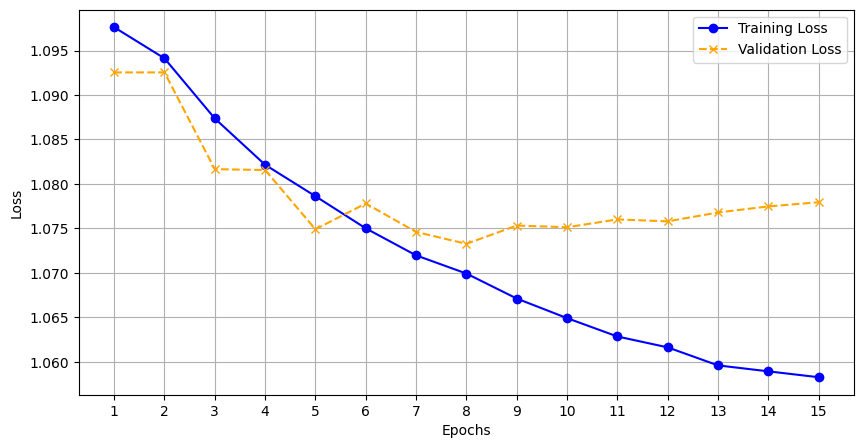

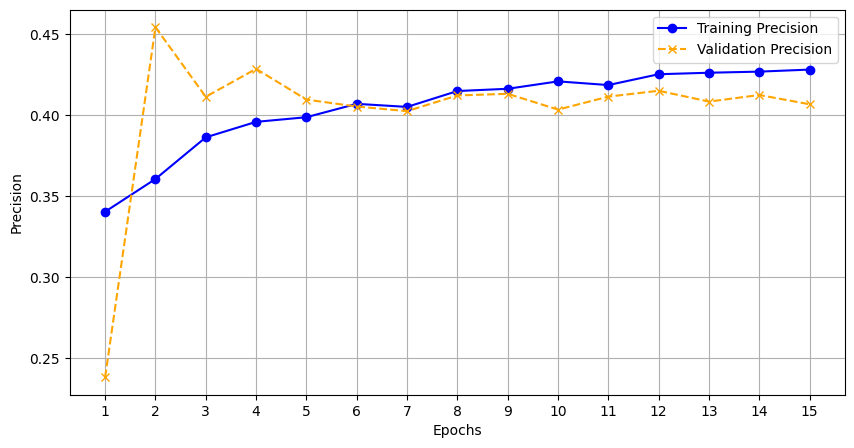

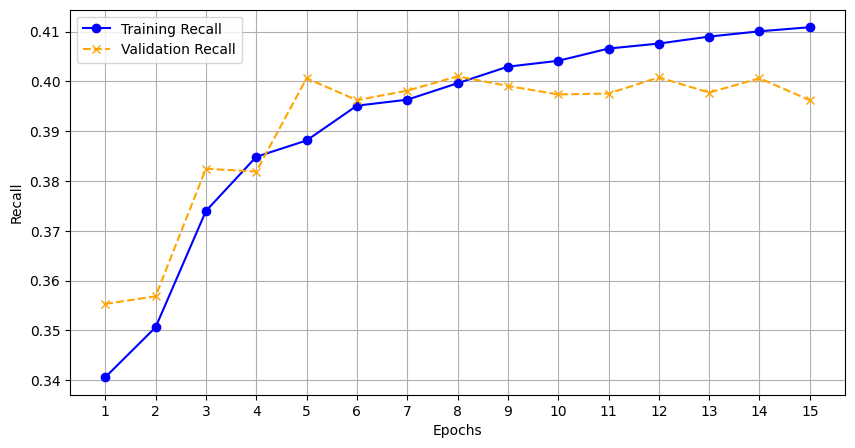

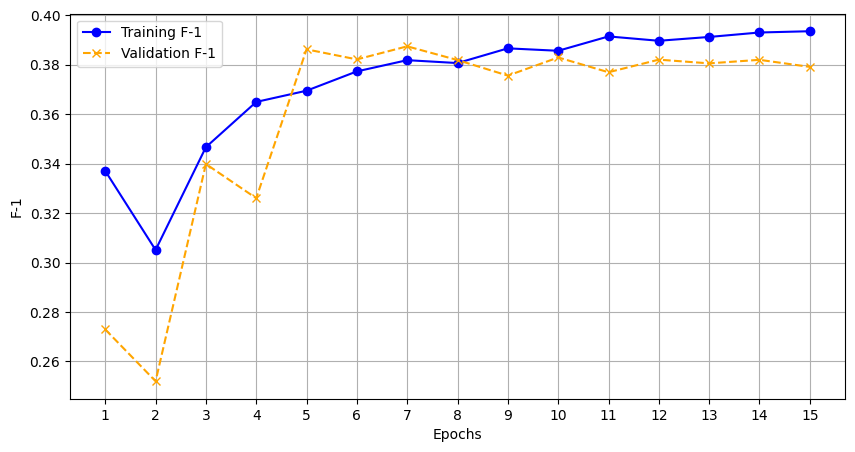

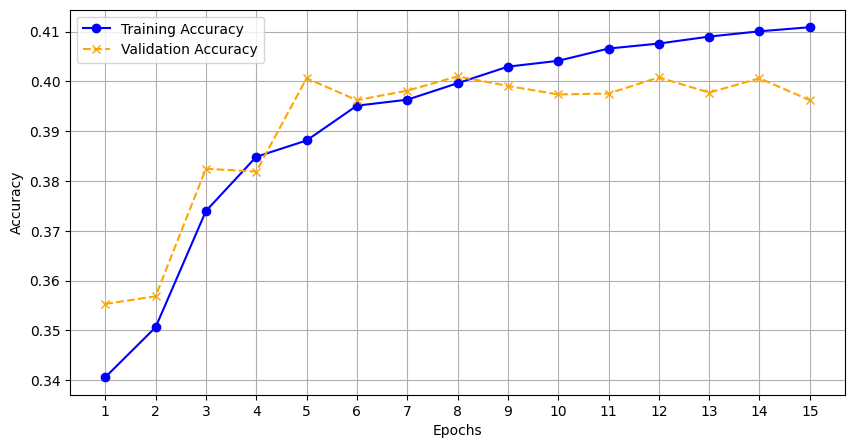

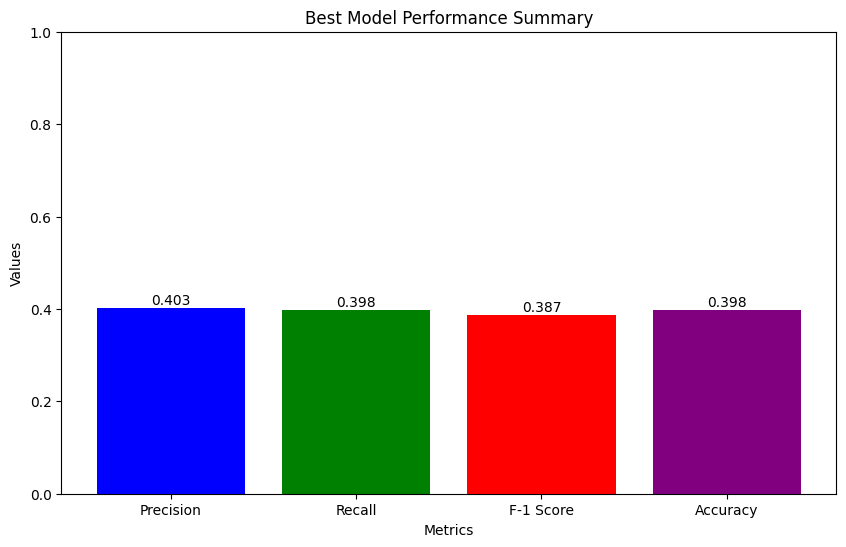

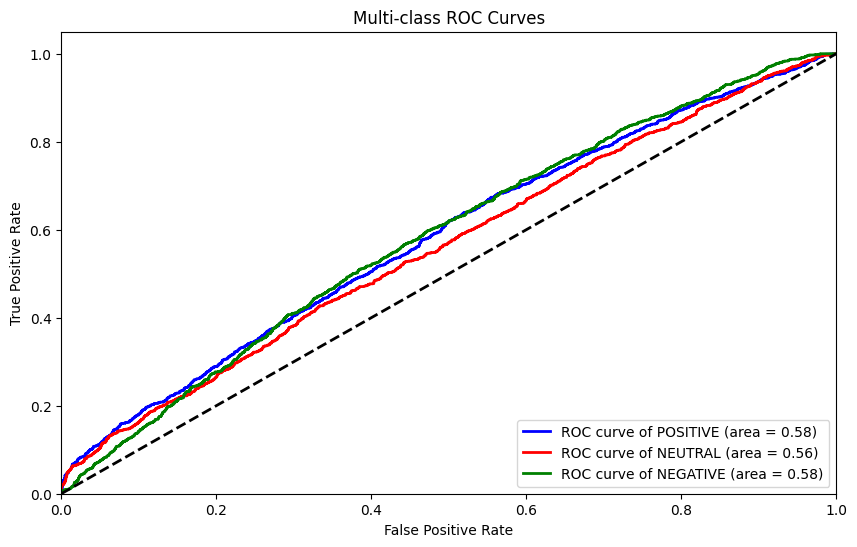

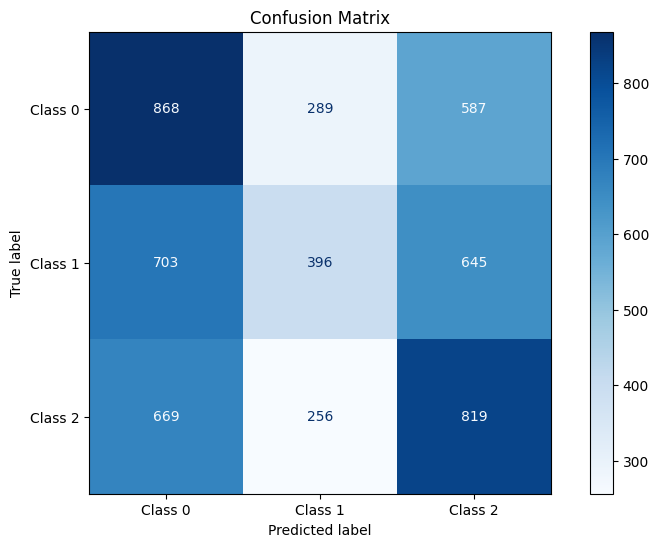

In [25]:
plots = Plot.plot_all(metrics,labels_and_predictions,probabilities,best_model_metrics)
Save.save_plots(plots,embedding_dimension,hyperparameters,best_model_metrics)

In [26]:
test_set = preprocessor.preprocess_dataset(test_set_url)
test_loader = DataLoader(test_set, batch_size=hyperparameters["data"]["batch_size"], shuffle=False)

In [27]:
# NEURAL NETWORK TEST SET PREDICTIONS

test_set_predictions = neural_network.predict(test_loader)
test_set_predictions = preprocessor.encode_sentiments(test_set_predictions,to_numbers=False)

In [28]:
# PREDICTION SAVING

Save.save_predictions(test_set_url,test_set_predictions)